In [1]:
#optiver volatility prediction
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('/Users/ericp/OneDrive/Documents/GitHub/Optiver/train.csv')
test = pd.read_csv('/Users/ericp/OneDrive/Documents/GitHub/Optiver/test.csv')
order_book = pd.read_parquet('/Users/ericp/OneDrive/Documents/GitHub/Optiver/book_train.parquet/stock_id=0')
trade_book = pd.read_parquet('/Users/ericp/OneDrive/Documents/GitHub/Optiver/trade_train.parquet/stock_id=0')

In [3]:
train.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [4]:
order_book.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100


In [5]:
trade_book.head()

,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1


In [6]:
#preprocess a file
def preprocess_order(path, predictionColumn):
    #read file
    file = pd.read_parquet(path)
    #create stock_id
    stock_id = path.split('=')[1]
    
    #create top of book wt avg
    file['wt_avg1'] = (file['bid_price1'] * file['ask_size1'] + 
                                   file['ask_price1'] * file['bid_size1'])  / (file['bid_size1'] + file['ask_size1'])

    #create 2nd level wt avg
    file['wt_avg2'] = (file['bid_price2'] * file['ask_size2'] + 
                                   file['ask_price2'] * file['bid_size2']) / (file['bid_size2'] + file['ask_size2'])

    #create mid point
    file['mid_pt'] = (file['bid_price1'] + file['ask_price1']) / 2

    #create spread 
    file['spread1'] = file['ask_price1'] - file['bid_price1'] 
    file['spread2'] = file['ask_price2'] - file['bid_price2']
    file['bid_spread'] = abs(file['bid_price1'] - file['bid_price2'])
    file['ask_spread'] = abs(file['ask_price1'] - file['ask_price2'])
    
    #total volume
    file['total_volume'] = file['bid_size1'] + file['bid_size2'] + file['ask_size1'] + file['ask_size2']
    #volume imbalances
    file['volume_imbalance'] = file['bid_size1'] / file['ask_size1']
    file['volume_imbalance2'] = file['bid_size2'] / file['ask_size2']
    file['total_volume'] = file['bid_size1'] + file['bid_size2'] + file['ask_size1'] + file['ask_size2']
    
    #create logdifferences
    file['logDifferences'] = file.groupby(['time_id'])['wt_avg1'].apply(logDiff)
    file['logDifferences2'] = file.groupby(['time_id'])['wt_avg2'].apply(logDiff)
    file = file[file['logDifferences'].notnull()]
    
    #add stock_id
    file['stock_id'] = stock_id
    
    #dict for aggregate
    create_feature_dct = {
        'logDifferences':[realized_vol],
        'logDifferences2':[realized_vol],
        'wt_avg1':[np.mean],
        'wt_avg2':[np.mean],
        'spread1':[np.mean],
        'spread2':[np.mean],
        'bid_spread':[np.mean],
        'ask_spread':[np.mean],
        'volume_imbalance':[np.mean],
        'volume_imbalance2':[np.mean],
        'total_volume':[np.mean]
            }
    
    
    #agg stats
    df_agg = pd.DataFrame(file.groupby(['time_id']).agg(create_feature_dct)).reset_index()
    df_agg = df_agg.rename(columns = {'logDifferences': predictionColumn})

    #stats from last 300 seconds 
    second = 300
    df_feature_sec = pd.DataFrame(file.query(f'seconds_in_bucket >= {second}').groupby(['time_id']).agg(create_feature_dct)).reset_index()
    df_feature_sec = df_feature_sec.iloc[:,1:12]

    #add row_id
    df_agg['row_id'] = str(stock_id) + '-' + df_agg['time_id'].apply(str)
    df_agg['stock_id'] = stock_id
    
    df_agg.columns = ['time_id', 'target', 'target2', 'wt_avg1_mean', 'wt_avg2_mean', 'spread1_mean', 'spread2_mean', 'bid_spread_mean',
                     'ask_spread_mean', 'volume_imbalance_mean', 'volume_imbalance2_mean', 'total_volume_mean', 'row_id', 'stock_id']

    df_feature_sec.columns = ['target_300', 'target2_300', 'wt_avg1_mean_300', 'wt_avg2_mean_300', 'spread1_mean_300',
                             'spread2_mean_300', 'bid_spread_mean_300', 'ask_spread_mean_300', 'volume_imbalance_mean_300', 
                             'volume_imbalance2_mean_300','total_volume_mean_300']

    #concat the two dfs
    df_agg = pd.concat([df_agg, df_feature_sec], axis = 1)
    
    df_agg = df_agg.drop(['time_id'], axis = 1)
    
    return df_agg

In [7]:
#create log diffs
def logDiff(stock_prices):
    return np.log(stock_prices).diff()

In [8]:
#create realized vols for each time / stock price
def realized_vol(log_diffs):
    return np.sqrt(np.sum(log_diffs ** 2))

In [9]:
import glob
orderPath = glob.glob('/Users/ericp/OneDrive/Documents/GitHub/Optiver/book_train.parquet/*')
df_order = preprocess_order(orderPath[0], 'target')

In [10]:
df_order.head()

,target,target2,wt_avg1_mean,wt_avg2_mean,spread1_mean,spread2_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,volume_imbalance2_mean,...,target2_300,wt_avg1_mean_300,wt_avg2_mean_300,spread1_mean_300,spread2_mean_300,bid_spread_mean_300,ask_spread_mean_300,volume_imbalance_mean_300,volume_imbalance2_mean_300,total_volume_mean_300
0,0.004499,0.006999,1.003733,1.003668,0.000855,0.001182,0.000176,0.000151,12.256744,10.161549,...,0.004864,1.003753,1.003667,0.000825,0.001210,0.000223,0.000162,15.356829,13.477168,294.928058
1,0.001204,0.002476,1.000240,1.000208,0.000393,0.000670,0.000142,0.000135,30.084782,7.376954,...,0.002009,1.000397,1.000346,0.000353,0.000640,0.000164,0.000123,35.009031,9.413341,484.521739
2,0.002369,0.004801,0.999541,0.999682,0.000724,0.001118,0.000196,0.000198,3.572455,13.897751,...,0.003196,0.998685,0.998935,0.000688,0.001079,0.000141,0.000249,0.562839,3.074708,455.235294
3,0.002574,0.003637,0.998819,0.998624,0.000861,0.001161,0.000191,0.000109,10.905228,1.060280,...,0.002713,0.998436,0.998455,0.000832,0.001085,0.000158,0.000095,13.218348,1.853489,418.169811
4,0.001894,0.003257,0.999616,0.999624,0.000396,0.000695,0.000190,0.000109,21.260113,19.871256,...,0.002188,0.999488,0.999615,0.000425,0.000736,0.000191,0.000120,10.770719,30.663623,407.584270


In [11]:
def preprocess_trade(path):
     #read file
    file = pd.read_parquet(path)
    #create stock_id
    stock_id = path.split('=')[1]
        
    #dictionary agg stats
    create_feature_dct = {
        'price':[np.std],
        'size': [np.sum],
        'order_count':[np.sum]        
    }
    
    #create agg stats
    df_agg = pd.DataFrame(file.groupby(['time_id']).agg(create_feature_dct)).reset_index()
    
    #create row_id
    df_agg['row_id'] = str(stock_id) + '-' + df_agg['time_id'].apply(str)
    df_agg = df_agg.drop(['time_id'], axis = 1)
    df_agg.columns = ['price_std', 'size_sum', 'order_count_sum', 'row_id']
  
    return df_agg
    

In [12]:
tradePath = glob.glob('/Users/ericp/OneDrive/Documents/GitHub/Optiver/trade_train.parquet/*')
df_trade = preprocess_trade(tradePath[0])

In [13]:
df_trade

,price_std,size_sum,order_count_sum,row_id
0,0.000578,3179,110,0-5
1,0.000304,1289,57,0-11
2,0.000932,2161,68,0-16
3,0.000729,1962,59,0-31
4,0.000182,1791,89,0-62
...,...,...,...,...
3825,0.000714,3450,159,0-32751
3826,0.000479,4547,109,0-32753
3827,0.000695,4250,126,0-32758
3828,0.000342,3217,114,0-32763


In [14]:
df = pd.merge(df_order, df_trade, on = 'row_id', how = 'right')
df['stock_id'] = 0

In [15]:
df.shape

(3830, 27)

In [16]:
df.head()

,target,target2,wt_avg1_mean,wt_avg2_mean,spread1_mean,spread2_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,volume_imbalance2_mean,...,spread1_mean_300,spread2_mean_300,bid_spread_mean_300,ask_spread_mean_300,volume_imbalance_mean_300,volume_imbalance2_mean_300,total_volume_mean_300,price_std,size_sum,order_count_sum
0,0.004499,0.006999,1.003733,1.003668,0.000855,0.001182,0.000176,0.000151,12.256744,10.161549,...,0.000825,0.001210,0.000223,0.000162,15.356829,13.477168,294.928058,0.000578,3179,110
1,0.001204,0.002476,1.000240,1.000208,0.000393,0.000670,0.000142,0.000135,30.084782,7.376954,...,0.000353,0.000640,0.000164,0.000123,35.009031,9.413341,484.521739,0.000304,1289,57
2,0.002369,0.004801,0.999541,0.999682,0.000724,0.001118,0.000196,0.000198,3.572455,13.897751,...,0.000688,0.001079,0.000141,0.000249,0.562839,3.074708,455.235294,0.000932,2161,68
3,0.002574,0.003637,0.998819,0.998624,0.000861,0.001161,0.000191,0.000109,10.905228,1.060280,...,0.000832,0.001085,0.000158,0.000095,13.218348,1.853489,418.169811,0.000729,1962,59
4,0.001894,0.003257,0.999616,0.999624,0.000396,0.000695,0.000190,0.000109,21.260113,19.871256,...,0.000425,0.000736,0.000191,0.000120,10.770719,30.663623,407.584270,0.000182,1791,89


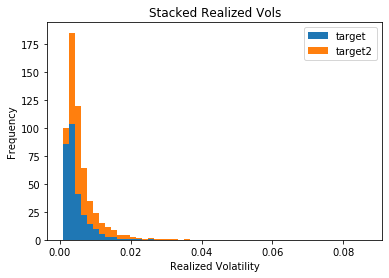

In [17]:
#EDAn_bins=30
colors = ['blue', 'green']
n_bins = 50
plt.hist([df['target'], df['target2']], n_bins, stacked=True, density = True, label=['target', 'target2'])
plt.legend(loc="upper right")
plt.title('Stacked Realized Vols')
plt.ylabel('Frequency')
plt.xlabel('Realized Volatility')
plt.show()
#vols a right skewed. heavily grouped around low vols. 

In [18]:
print('targets greater than 0.03 is {}'.format(len(df[df['target'] > 0.03])))
print('target2 greater than 0.03 is {}'.format(len(df[df['target2'] > 0.03])))

targets greater than 0.03 is 5
target2 greater than 0.03 is 35


In [20]:
print('total number of stocks is {}'.format(len(train['stock_id'].unique())))
print('total number of time_id is {}'.format(len(train)))

total number of stocks is 112
total number of time_id is 428932


In [21]:
#create RMSPE metric
def RMSPE(vols, truth):         
    return np.sqrt(np.sum(np.mean(np.square((vols - truth)/truth))))   

In [22]:
#lgb model
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

X= df.drop(['target', 'row_id'], axis = 1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X,y)
print('Shape of X_test is {}'.format(X_train.shape))
print('Shape of X_train is {}'.format(X_test.shape))
print('Shape of y_test is {}'.format(y_test.shape))
print('Shape of y_train is {}'.format(y_train.shape))

params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'rmse'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10

Shape of X_test is (2872, 25)
Shape of X_train is (958, 25)
Shape of y_test is (958,)
Shape of y_train is (2872,)


In [23]:
train_dataset = lgb.Dataset(X_train, y_train)
test_dataset = lgb.Dataset(X_test, y_test)

model = lgb.train(params, train_set=train_dataset, valid_sets=(test_dataset,), num_boost_round=10)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6107
[LightGBM] [Info] Number of data points in the train set: 2872, number of used features: 24
[LightGBM] [Info] Start training from score 0.004471
[1]	valid_0's rmse: 0.00341379
[2]	valid_0's rmse: 0.00340378
[3]	valid_0's rmse: 0.00339443
[4]	valid_0's rmse: 0.00338481
[5]	valid_0's rmse: 0.00337552
[6]	valid_0's rmse: 0.00336563
[7]	valid_0's rmse: 0.00335575
[8]	valid_0's rmse: 0.00334592
[9]	valid_0's rmse: 0.00333613
[10]	valid_0's rmse: 0.00332629


In [27]:
order_book.shape

(917553, 10)